In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.2 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 35329 
    Total predicted counts          : 34850.88
    Total off counts                : 101263.00

    Total background counts         : 20252.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 3.89 s, sys: 22.3 ms, total: 3.91 s
Wall time: 3.96 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 35056 
    Total predicted counts          : 35011.28
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 34660 
    Total predicted counts          : 34896.08
    Total off counts                : 101489.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_11 

    Total counts                    : 34895 
    Total predicted counts          : 34899.28
    Total off counts                : 101505.00

    Total background counts         : 20301.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_12 

    Total counts                    : 34910 
    Total predicted counts          : 34967.48
    Total off counts                : 101846.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_27 

    Total counts                    : 34797 
    Total predicted counts          : 34827.68
    Total off counts                : 101147.00

    Total background counts         : 20229.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_28 

    Total counts                    : 34722 
    Total predicted counts          : 34815.88
    Total off counts                : 101088.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_43 

    Total counts                    : 35058 
    Total predicted counts          : 34888.28
    Total off counts                : 101450.00

    Total background counts         : 20290.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_44 

    Total counts                    : 35071 
    Total predicted counts          : 34992.08
    Total off counts                : 101969.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_59 

    Total counts                    : 35010 
    Total predicted counts          : 34940.88
    Total off counts                : 101713.00

    Total background counts         : 20342.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_60 

    Total counts                    : 34782 
    Total predicted counts          : 34937.68
    Total off counts                : 101697.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_79 

    Total counts                    : 34981 
    Total predicted counts          : 34859.28
    Total off counts                : 101305.00

    Total background counts         : 20261.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_80 

    Total counts                    : 34899 
    Total predicted counts          : 34941.28
    Total off counts                : 101715.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_98 

    Total counts                    : 34944 
    Total predicted counts          : 34877.48
    Total off counts                : 101396.00

    Total background counts         : 20279.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_99 

    Total counts                    : 34964 
    Total predicted counts          : 34899.08
    Total off counts                : 101504.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_123 

    Total counts                    : 34987 
    Total predicted counts          : 34906.48
    Total off counts                : 101541.00

    Total background counts         : 20308.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_124 

    Total counts                    : 34976 
    Total predicted counts          : 34995.68
    Total off counts                : 101987.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_145 

    Total counts                    : 34945 
    Total predicted counts          : 35014.48
    Total off counts                : 102081.00

    Total background counts         : 20416.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_146 

    Total counts                    : 34890 
    Total predicted counts          : 35001.48
    Total off counts                : 102016.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_161 

    Total counts                    : 35147 
    Total predicted counts          : 34927.68
    Total off counts                : 101647.00

    Total background counts         : 20329.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_162 

    Total counts                    : 35053 
    Total predicted counts          : 34885.88
    Total off counts                : 101438.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_178 

    Total counts                    : 35127 
    Total predicted counts          : 34984.68
    Total off counts                : 101932.00

    Total background counts         : 20386.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_179 

    Total counts                    : 35027 
    Total predicted counts          : 34923.28
    Total off counts                : 101625.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_193 

    Total counts                    : 34814 
    Total predicted counts          : 34933.48
    Total off counts                : 101676.00

    Total background counts         : 20335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_194 

    Total counts                    : 34727 
    Total predicted counts          : 34929.88
    Total off counts                : 101658.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_211 

    Total counts                    : 35498 
    Total predicted counts          : 34848.08
    Total off counts                : 101249.00

    Total background counts         : 20249.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_212 

    Total counts                    : 34617 
    Total predicted counts          : 34943.28
    Total off counts                : 101725.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_224 

    Total counts                    : 34874 
    Total predicted counts          : 34903.28
    Total off counts                : 101525.00

    Total background counts         : 20305.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_225 

    Total counts                    : 34845 
    Total predicted counts          : 34882.08
    Total off counts                : 101419.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_243 

    Total counts                    : 34735 
    Total predicted counts          : 34984.88
    Total off counts                : 101933.00

    Total background counts         : 20386.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_244 

    Total counts                    : 34909 
    Total predicted counts          : 34931.68
    Total off counts                : 101667.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_266 

    Total counts                    : 34791 
    Total predicted counts          : 34959.08
    Total off counts                : 101804.00

    Total background counts         : 20360.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_267 

    Total counts                    : 34921 
    Total predicted counts          : 34955.68
    Total off counts                : 101787.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_288 

    Total counts                    : 35095 
    Total predicted counts          : 35015.88
    Total off counts                : 102088.00

    Total background counts         : 20417.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_289 

    Total counts                    : 34726 
    Total predicted counts          : 34962.88
    Total off counts                : 101823.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_305 

    Total counts                    : 34816 
    Total predicted counts          : 34953.88
    Total off counts                : 101778.00

    Total background counts         : 20355.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_306 

    Total counts                    : 34941 
    Total predicted counts          : 34834.48
    Total off counts                : 101181.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_323 

    Total counts                    : 34933 
    Total predicted counts          : 34865.08
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_324 

    Total counts                    : 34544 
    Total predicted counts          : 34864.08
    Total off counts                : 101329.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_342 

    Total counts                    : 34874 
    Total predicted counts          : 34960.88
    Total off counts                : 101813.00

    Total background counts         : 20362.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_343 

    Total counts                    : 35038 
    Total predicted counts          : 34921.48
    Total off counts                : 101616.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_356 

    Total counts                    : 34999 
    Total predicted counts          : 34928.48
    Total off counts                : 101651.00

    Total background counts         : 20330.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_357 

    Total counts                    : 35047 
    Total predicted counts          : 34914.68
    Total off counts                : 101582.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_367 

    Total counts                    : 34843 
    Total predicted counts          : 34912.08
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_368 

    Total counts                    : 34948 
    Total predicted counts          : 34769.68
    Total off counts                : 100857.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_387 

    Total counts                    : 34854 
    Total predicted counts          : 34962.08
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_388 

    Total counts                    : 34868 
    Total predicted counts          : 34864.28
    Total off counts                : 101330.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_398 

    Total counts                    : 35052 
    Total predicted counts          : 34950.28
    Total off counts                : 101760.00

    Total background counts         : 20352.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_399 

    Total counts                    : 34802 
    Total predicted counts          : 34943.08
    Total off counts                : 101724.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_422 

    Total counts                    : 34960 
    Total predicted counts          : 34885.88
    Total off counts                : 101438.00

    Total background counts         : 20287.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_423 

    Total counts                    : 35052 
    Total predicted counts          : 34947.88
    Total off counts                : 101748.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_435 

    Total counts                    : 35234 
    Total predicted counts          : 34834.68
    Total off counts                : 101182.00

    Total background counts         : 20236.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_436 

    Total counts                    : 35023 
    Total predicted counts          : 34990.28
    Total off counts                : 101960.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_452 

    Total counts                    : 34729 
    Total predicted counts          : 34848.08
    Total off counts                : 101249.00

    Total background counts         : 20249.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_453 

    Total counts                    : 35033 
    Total predicted counts          : 35041.68
    Total off counts                : 102217.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_463 

    Total counts                    : 35089 
    Total predicted counts          : 34957.28
    Total off counts                : 101795.00

    Total background counts         : 20359.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_464 

    Total counts                    : 34804 
    Total predicted counts          : 34891.28
    Total off counts                : 101465.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_480 

    Total counts                    : 34893 
    Total predicted counts          : 34936.88
    Total off counts                : 101693.00

    Total background counts         : 20338.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_481 

    Total counts                    : 35042 
    Total predicted counts          : 34913.28
    Total off counts                : 101575.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_491 

    Total counts                    : 34639 
    Total predicted counts          : 34993.88
    Total off counts                : 101978.00

    Total background counts         : 20395.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_492 

    Total counts                    : 34972 
    Total predicted counts          : 35014.48
    Total off counts                : 102081.00

    Total background counts        

Text(0, 0.5, 'No. of observations')

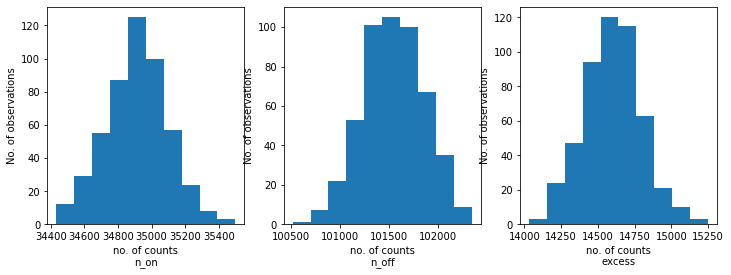

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 1min 33s, sys: 660 ms, total: 1min 33s
Wall time: 1min 34s


In [15]:
results

[{'index': 2.2065245213780615,
  'amplitude': 1.314624792989545e-12,
  'lambda_': 0.19822373303885332},
 {'index': 2.2241296518600198,
  'amplitude': 1.2597427958332657e-12,
  'lambda_': 0.19849869006038268},
 {'index': 2.2215816290774106,
  'amplitude': 1.2599389030670734e-12,
  'lambda_': 0.20433315945555797},
 {'index': 2.2255111002319556,
  'amplitude': 1.2639165786699223e-12,
  'lambda_': 0.20108668021471066},
 {'index': 2.2405402452329235,
  'amplitude': 1.2800212266093838e-12,
  'lambda_': 0.1987347318716423},
 {'index': 2.196569540293972,
  'amplitude': 1.3394190116344316e-12,
  'lambda_': 0.22642936450661244},
 {'index': 2.25270088300736,
  'amplitude': 1.218659850841904e-12,
  'lambda_': 0.1711351607368041},
 {'index': 2.2179245864540587,
  'amplitude': 1.3006138000014736e-12,
  'lambda_': 0.20956042677926046},
 {'index': 2.2087873646636726,
  'amplitude': 1.2841801081009587e-12,
  'lambda_': 0.19274956641335284},
 {'index': 2.249279839203157,
  'amplitude': 1.216292553466284

index: 2.2198331713885824 += 0.01651208698309843


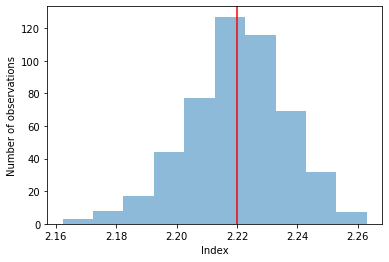

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2907475576083914e-12 += 4.056317942424548e-14


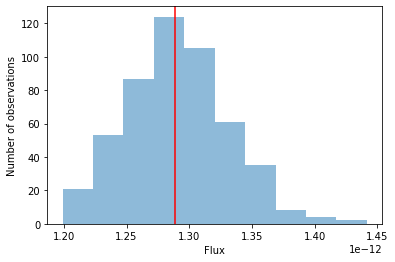

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.20107564110469348 += 0.016197457348760276


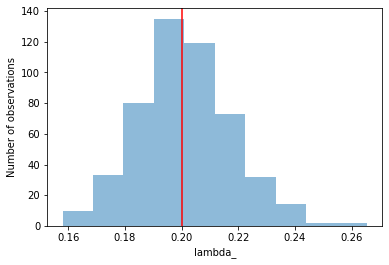

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")